# MLTraceability system: Scalable Blockchain Auditing System"

In [19]:
## Necessary imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle
import hashlib
import os
import matplotlib.pyplot as plt

In [13]:
# Load PIMA Indian Diabetes Dataset (Section 3.1)
## Source: GitHub mirror of UCI dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
local_file = 'pima-indians-diabetes.csv'

## Download or load locally
if not os.path.exists(local_file):
    try:
        data = pd.read_csv(url, header=None, names=columns)
        data.to_csv(local_file, index=False)  # Cache locally
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please download 'pima-indians-diabetes.csv' from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database and place it in the project directory.")
        exit(1)
else:
    data = pd.read_csv(local_file, header=None, names=columns)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
# Preprocessing (Section 3.2)
# Impute missing values (zeros) with median
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, data[col].median())

# Normalize features with Z-score
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('Outcome', axis=1))
y = data['Outcome']

# Data partitioning (Section 3.3): 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)  # 0.1765 = 15/(85)

In [15]:
# Hyperparameter tuning (Section 3.4)
## Logistic Regression
lr_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)

## Decision Tree
dt_param_grid = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy']}
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5]},
             scoring='f1')

In [16]:
# Evaluate models on test set (Section 4.5)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
    }

lr_metrics = evaluate_model(lr_grid.best_estimator_, X_test, y_test)
dt_metrics = evaluate_model(dt_grid.best_estimator_, X_test, y_test)

In [17]:
# Save models and generate hashes (Section 4.4)
with open('logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_grid.best_estimator_, f)
with open('decision_tree.pkl', 'wb') as f:
    pickle.dump(dt_grid.best_estimator_, f)

def compute_file_hash(file_path):
    sha256 = hashlib.sha256()
    with open(file_path, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b""):
            sha256.update(chunk)
    return sha256.hexdigest()

lr_hash = compute_file_hash('logistic_regression.pkl')
dt_hash = compute_file_hash('decision_tree.pkl')


In [22]:
# Print metrics for Table 1 (Section 4.5)
print("Logistic Regression Metrics:", lr_metrics)
print("Decision Tree Metrics:", dt_metrics)
print("Logistic Regression Model Hash:", lr_hash)
print("Decision Tree Model Hash:", dt_hash)

Logistic Regression Metrics: {'accuracy': 0.7327586206896551, 'precision': 0.6216216216216216, 'recall': 0.575, 'f1_score': 0.5974025974025974, 'confusion_matrix': [[62, 14], [17, 23]]}
Decision Tree Metrics: {'accuracy': 0.7155172413793104, 'precision': 0.6, 'recall': 0.525, 'f1_score': 0.56, 'confusion_matrix': [[62, 14], [19, 21]]}
Logistic Regression Model Hash: b3acf4555cfc80260529e5c25fda167c07e18502af3f0fd2f9ad945d77ad856f
Decision Tree Model Hash: 3e1e97bf6a86498590a28294840d00bd16023a8926b891798d05e4825de1ddc1


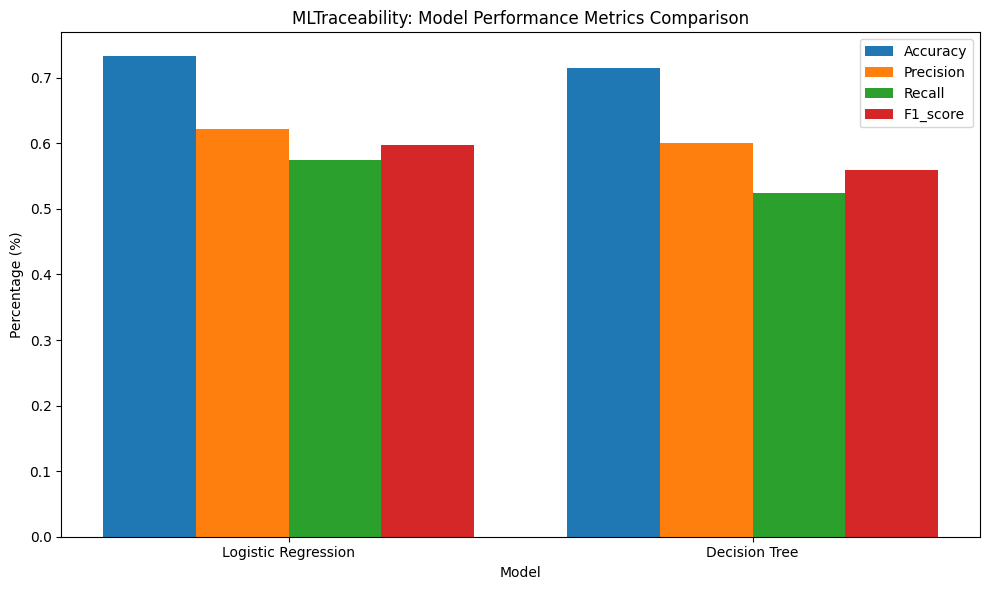

In [21]:
# Plot bar chart for metrics comparison (Section 4.5)
metrics = {'Logistic Regression': lr_metrics, 'Decision Tree': dt_metrics}
models = list(metrics.keys())
metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
bar_width = 0.2
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metric_names):
    values = [metrics[model][metric] for model in models]
    ax.bar(x + i * bar_width, values, bar_width, label=metric.capitalize())

ax.set_xlabel('Model')
ax.set_ylabel('Percentage (%)')
ax.set_title('MLTraceability: Model Performance Metrics Comparison')
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(models)
ax.legend()
plt.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()